# Assignment 2: The "Smart Labeling Pipeline" Challenge

**Total Marks: 20**

Build a cost-effective, high-quality labeling pipeline using human annotation, programmatic rules, and LLMs.

This notebook implements an end-to-end smart labeling pipeline to:
1. Establish gold standard through human annotation and measure inter-annotator agreement (6 marks)
2. Label data programmatically using weak supervision (Snorkel) (6 marks)
3. Optimize labeling budget using active learning (5 marks)
4. Leverage LLMs for bulk labeling and detect hallucinations (e.g. noisy labels) (3 marks)

## Setup and Imports

In [ ]:
!pip install snorkel

In [ ]:
!pip install snorkel statsmodels google-generativeai

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel
from statsmodels.stats.inter_rater import fleiss_kappa
import google.generativeai as genai
import time
from pathlib import Path
import re

## Task 1: The Human as Annotator (6 Marks)

**Objective:** Establish a "Gold Standard" dataset and measure human consensus.

### Part 1.1: Parse Annotator CSV Files

After annotating the first 100 reviews, export annotations from three annotators (A, B, C) as CSV files.
Parse these CSV files into clean DataFrames for analysis.

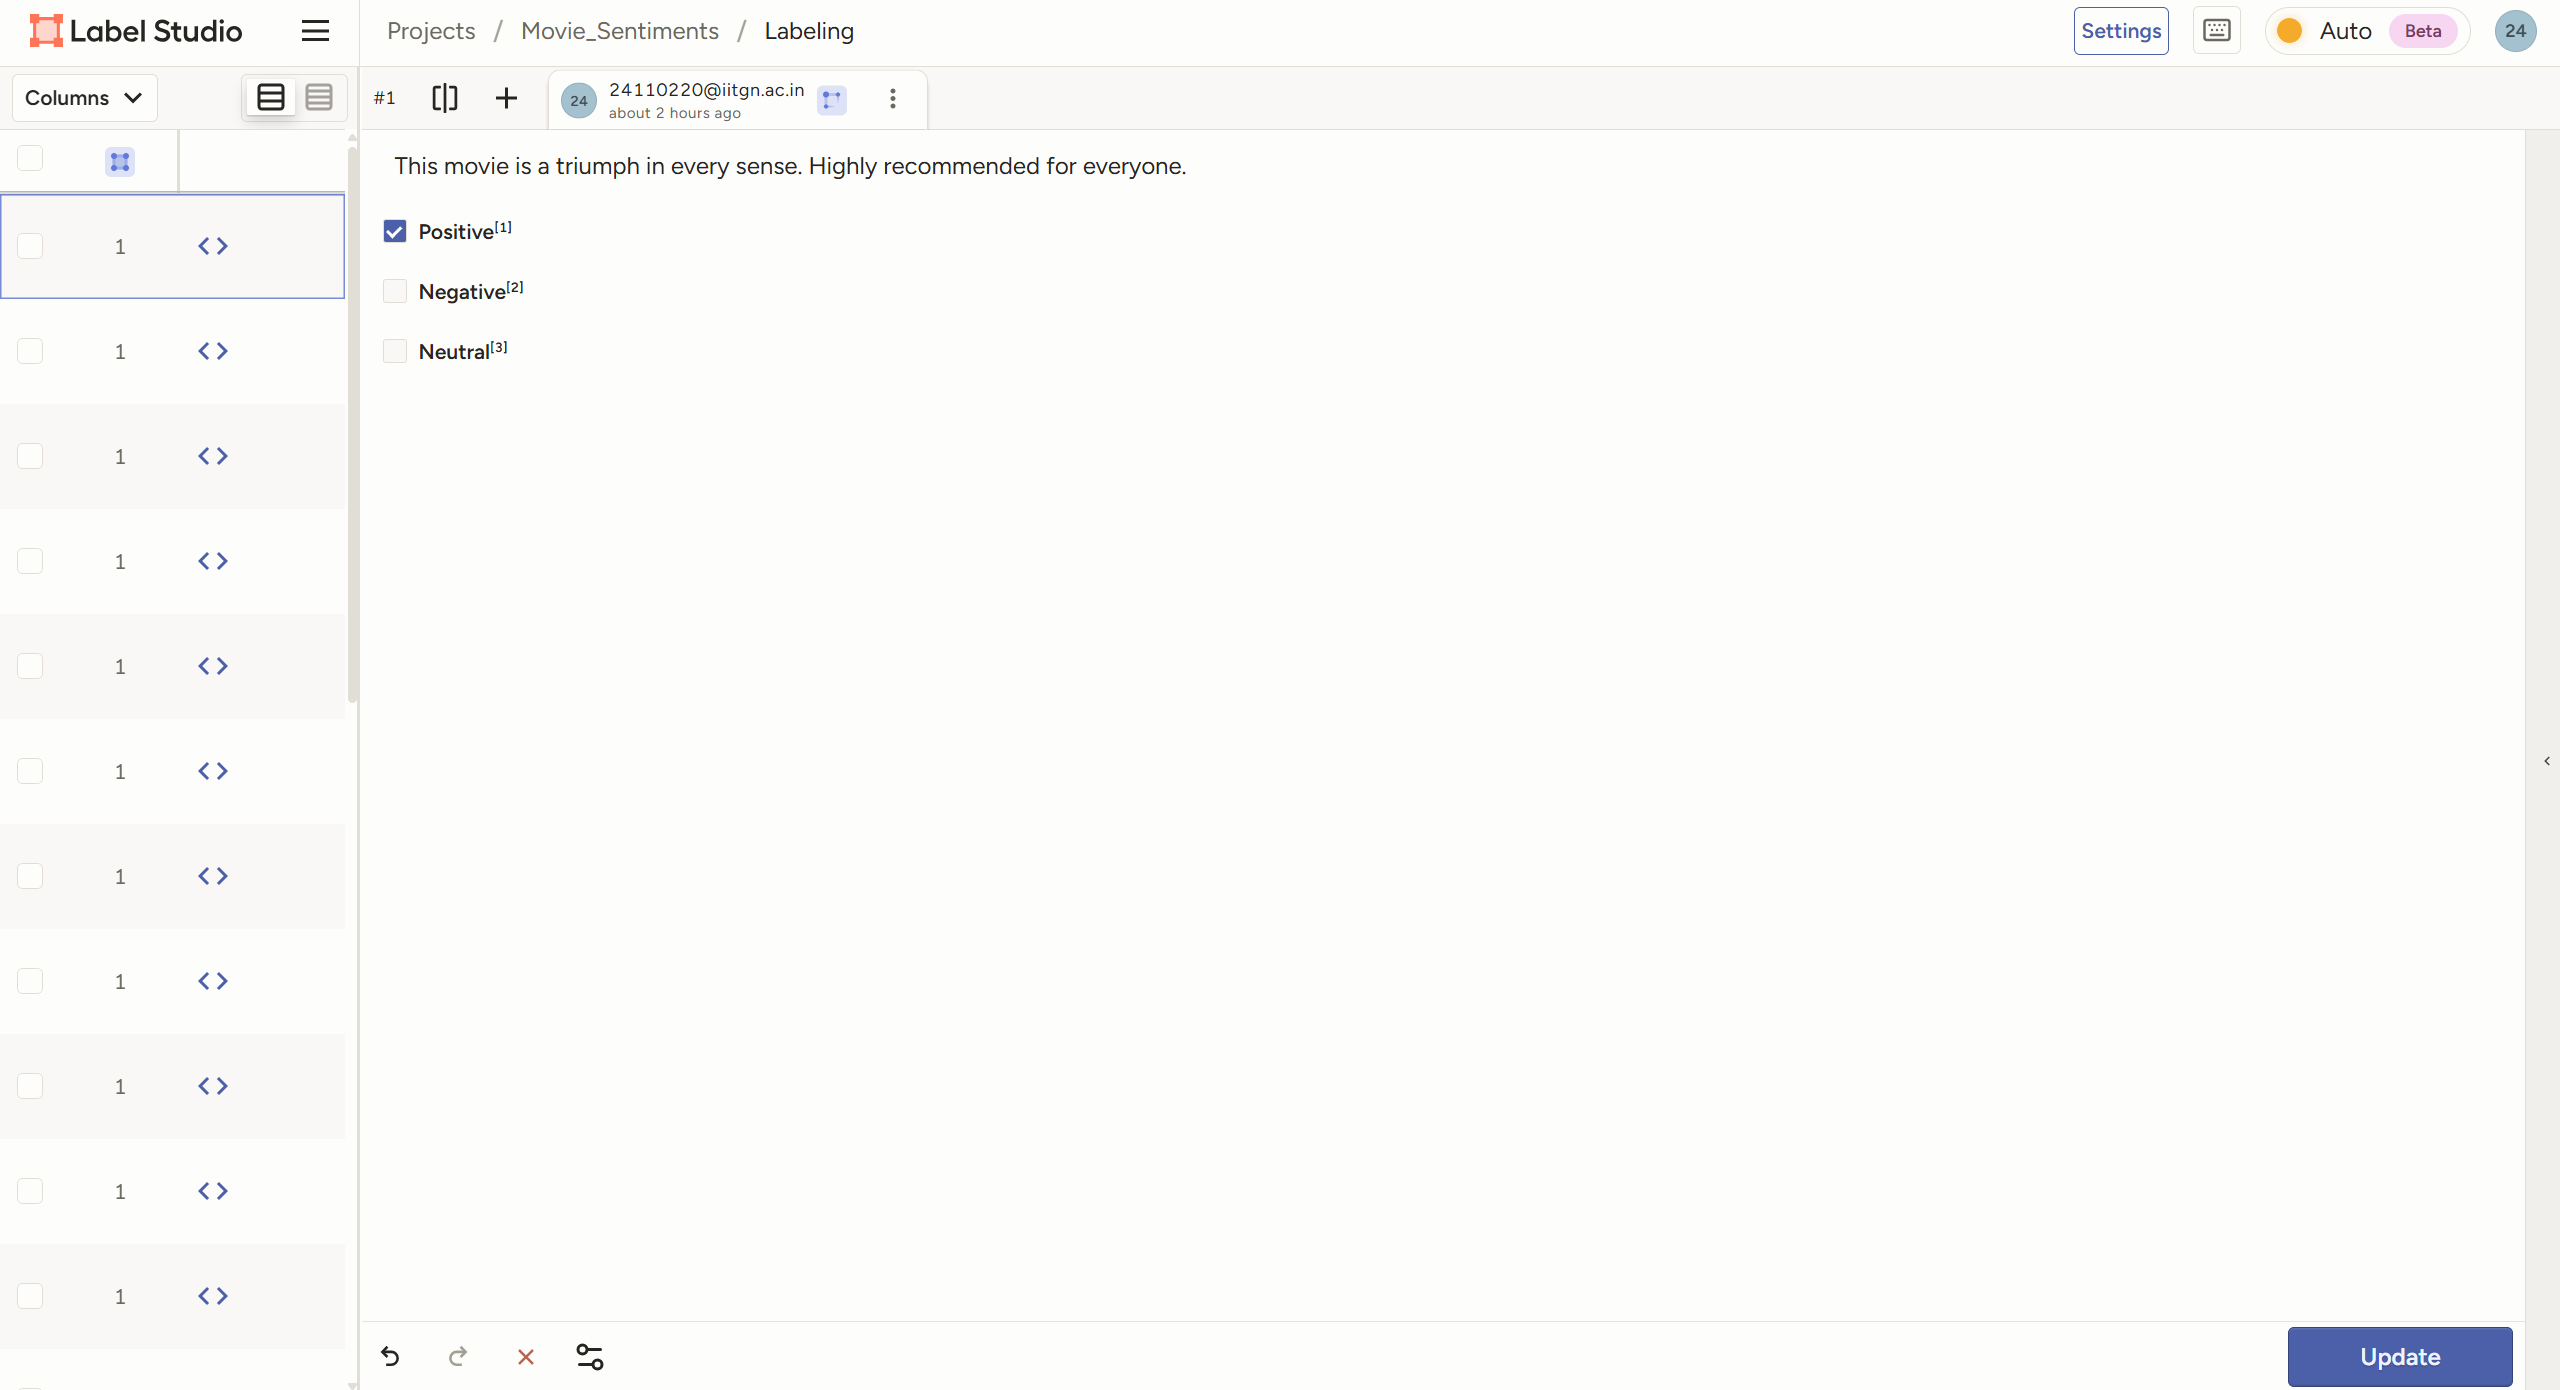

In [ ]:
def parse_annotator_csv(csv_path):
    """
    Parses annotator CSV file into a clean DataFrame.

    Args:
        csv_path (str): Path to annotator CSV file

    Returns:
        pd.DataFrame: DataFrame with columns ['review_id', 'review', 'label']
                     where label is one of: 'Positive', 'Negative', 'Neutral'

    Note:
        - Look for relevant column names in the CSV file
        - If column names differ, the function will try to map them appropriately
        - Finally, return with two columns 'review' and 'label'
    """
    # TODO: Load CSV file using pd.read_csv()

    df = pd.read_csv(csv_path)
    # print(df)
    final_df = df[['review', 'sentiment']]
    final_df.columns = ['review', 'label']

    return final_df
    # TODO: Check and map column names if needed


In [ ]:
# TODO: Parse CSV files (replace with actual file paths)
csv_path_a = r"/content/annotator_a.csv"
csv_path_b = r"/content/annotator_b.csv"
csv_path_c = r"/content/annotator_c.csv"
df_a = parse_annotator_csv(csv_path_a)
df_b = parse_annotator_csv(csv_path_b)
df_c = parse_annotator_csv(csv_path_c)
# Display sample data
df_a.head()

,review,label
0,This movie is a triumph in every sense. Highly...,Positive
1,I have never been so bored in my life. The sco...,Negative
2,I was completely blown away by this film. The ...,Positive
3,The trailer was better than the movie. The act...,Negative
4,Middle of the road entertainment. Visually it'...,Neutral


### Part 1.2: Implement Fleiss' Kappa from Scratch

Measure inter-annotator agreement using Fleiss' Kappa statistic.
Implement the formula from scratch and compare with statsmodels implementation.

In [ ]:
def fleiss_kappa_scratch(rating_matrix):
    """
    Computes Fleiss' Kappa for multiple raters from scratch.

    Args:
        rating_matrix (np.array): A Count Matrix of shape (N, k).
                                  - N = number of items (rows)
                                  - k = number of categories (columns)
                                  - Element [i, j] = Count of raters who assigned category j to item i.
                                  Example:
                                    [[0, 0, 3],   # Item 0: All 3 raters said Category 2
                                     [1, 2, 0]]   # Item 1: 1 rater said Cat 0, 2 said Cat 1


    Returns:
        float: Kappa score (ranges from -1 to 1, where 1 = perfect agreement)

    Formula:
        κ = (P_bar - P_e_bar) / (1 - P_e_bar)

        where:
        - P_bar = (1/N) * Σ(P_i) = average proportion of agreement across all items
        - P_i = (1/(n*(n-1))) * Σ(k_ij * (k_ij - 1)) for item i
        - P_e_bar = Σ(p_j^2) = expected agreement by chance
        - p_j = proportion of all assignments to category j

    Note:
        - N = number of items (samples)
        - n = number of raters per item (should be constant)
        - k_ij = number of raters who assigned category j to item i
    """
    # TODO: Calculate P_bar (observed agreement), P_e_bar (expected agreement by chance), Apply the formula: κ = (P_bar - P_e_bar) / (1 - P_e_bar)
    k = rating_matrix.shape[1]
    N = rating_matrix.shape[0]
    n = np.sum(rating_matrix[0])
    P_bar = 0
    P_e_bar = 0
    P_j = rating_matrix.sum(axis=0) / (N * n)
    P_e_bar = np.sum(P_j**2)

    for i in range(N):
      agreement_sum=0

      for j in range(k):
        agreement_sum += rating_matrix[i][j] * (rating_matrix[i][j] - 1)

      P_i = (1/(n*(n-1))) * agreement_sum
      P_bar += P_i

    P_bar= P_bar/N
    k = (P_bar - P_e_bar) / (1 - P_e_bar)

    return k

In [ ]:
def prepare_rating_matrix(df_a, df_b, df_c):
    """
    Converts three DataFrames into a rating matrix for Fleiss' Kappa calculation.

    Args:
        df_a, df_b, df_c: DataFrames with columns ['review_id', 'review', 'label']

    Returns:
        np.array: Rating matrix of shape (N_samples, N_categories)
                  where categories are ['Negative', 'Neutral', 'Positive']
    """
    # TODO: Merge the three DataFrames on review
    # Hint: Use pd.merge() or pd.concat() with proper keys
    merged = df_a[['review', 'label']] \
        .merge(df_b[['review', 'label']], on='review', suffixes=('_a', '_b')) \
        .merge(df_c[['review', 'label']], on='review')

    merged = merged.rename(columns = {'label': 'label_c'})

    categories = ['Negative', 'Neutral', 'Positive']

    rating_matrix = []

    for _, row in merged.iterrows():
        rating_matrix.append([
            (row['label_a'] == 'Negative') +
            (row['label_b'] == 'Negative') +
            (row['label_c'] == 'Negative'),

            (row['label_a'] == 'Neutral') +
            (row['label_b'] == 'Neutral') +
            (row['label_c'] == 'Neutral'),

            (row['label_a'] == 'Positive') +
            (row['label_b'] == 'Positive') +
            (row['label_c'] == 'Positive')
        ])

    return np.array(rating_matrix)



    # TODO: Return numpy array of shape (N_samples, 3)
    # Order: [Negative_count, Neutral_count, Positive_count] for each row



# TODO: Prepare rating matrix and calculate Fleiss' Kappa
rating_matrix = prepare_rating_matrix(df_a, df_b, df_c)
# TODO: Use statsmodels to calculate Fleiss' Kappa
fleiss_kappa_statsmodels = fleiss_kappa(rating_matrix)
# TODO: Print the difference between the two implementations
kappa = fleiss_kappa_scratch(rating_matrix)
print(f"Fleiss' Kappa (Scratch): {kappa}")
print(f"Fleiss' Kappa (Statsmodels): {fleiss_kappa_statsmodels}")


Fleiss' Kappa (Scratch): 0.7775455863022007
Fleiss' Kappa (Statsmodels): 0.7775455863022008


### Part 1.3: Conflict Resolution

Identify conflicts where annotators disagree and resolve them using majority vote.
For complete ties (all three differ), default to 'Neutral'.

In [ ]:
def resolve_conflicts(df_a, df_b, df_c):
    """
    Merges annotations from 3 annotators, resolves disagreements using Majority Vote,
    and handles complete ties by defaulting to 'Neutral'.

    Args:
        df_a, df_b, df_c: DataFrames from each annotator with columns ['review', 'label']

    Returns:
        pd.DataFrame: Final DataFrame with resolved labels (gold standard)
                     Columns: ['review', 'label']

    Logic:
        - Majority Vote: If 2 annotators agree, use their label
        - Tie-Breaker: If all 3 differ (e.g., Positive vs. Negative vs. Neutral), assign 'Neutral'
    """
    data = prepare_rating_matrix(df_a, df_b, df_c)
    resolved_labels = []
    for row in data:
      if np.all(row == row[0]):
        resolved_labels.append('Neutral')
      else:
        idx = np.argmax(row)

        if idx == 0:
            resolved_labels.append('Negative')
        elif idx == 1:
            resolved_labels.append('Neutral')
        else:
            resolved_labels.append('Positive')

    gold_df = pd.DataFrame({'review': df_a['review'], 'label': resolved_labels})

    return gold_df

In [ ]:
# TODO: Resolve conflicts and create gold standard

# TODO: Display 5 examples of conflicting reviews (if <5 reviews, show all)
# Show what A, B, and C each said, and the final resolved label
rating_matrix = prepare_rating_matrix(df_a, df_b, df_c)
conflict_indices = np.where(~np.any(rating_matrix == 3, axis=1))[0]
gold_df = resolve_conflicts(df_a, df_b, df_c)
print(f"Number of conflicts: {len(conflict_indices)}")
for idx in conflict_indices[:5]:
  print("Review")
  print(df_a.iloc[idx]['review'])
  print("A: ", df_a.iloc[idx]['label'])
  print("B: ", df_b.iloc[idx]['label'])
  print("C: ", df_c.iloc[idx]['label'])
  print("Resolved Label: ", gold_df.iloc[idx]['label'])
# TODO: Save gold standard to CSV
gold_df.to_csv('gold_standard_100.csv', index=False)

Number of conflicts: 22
Review
I oscillated between loving and hating this film. I respect the ambition, even if it didn't fully land.
A:  Positive
B:  Neutral
C:  Neutral
Resolved Label:  Neutral
Review
The acting was gripping, yet the acting felt dull. This is a very difficult movie to categorize.
A:  Negative
B:  Neutral
C:  Negative
Resolved Label:  Negative
Review
It tries to be deep, but comes off as dull despite the gripping music. A strange experience overall.
A:  Negative
B:  Neutral
C:  Negative
Resolved Label:  Negative
Review
The direction was typical, but nothing special. Middle of the road entertainment.
A:  Negative
B:  Neutral
C:  Neutral
Resolved Label:  Neutral
Review
I tried to like it, I really did, but it failed. I walked out halfway through.
A:  Negative
B:  Neutral
C:  Negative
Resolved Label:  Negative


## Task 2: Weak Supervision (The "Lazy" Labeler) (6 Marks)

**Objective:** Label the next 200 reviews programmatically to save time.

### Part 2.1: Heuristic Development

Analyze patterns in the gold standard and write at least 3 heuristic functions.
Apply them to the remaining 200 unlabeled reviews.

In [ ]:
# Constants for labeling functions
POSITIVE = 1
NEGATIVE = 0
NEUTRAL = 2
ABSTAIN = -1

# TODO: Load gold standard to analyze patterns
df = pd.read_csv("/content/gold_standard_100.csv")

# TODO: Analyze patterns (e.g., common positive/negative words, review length, etc.)
df.head()
# This will help you design effective heuristics

,review,label
0,This movie is a triumph in every sense. Highly...,Positive
1,I have never been so bored in my life. The sco...,Negative
2,I was completely blown away by this film. The ...,Positive
3,The trailer was better than the movie. The act...,Negative
4,Middle of the road entertainment. Visually it'...,Neutral


### Part 2.2: Snorkel Labeling Functions

Wrap your heuristics as Snorkel @labeling_function decorators.
Each function should return POSITIVE (1), NEGATIVE (0), NEUTRAL (2), or ABSTAIN (-1).

In [ ]:
@labeling_function()
def lf_keyword_great(x):
    """
    Example labeling function: Check if "great" appears in the review.
    Returns POSITIVE if found, otherwise ABSTAIN.
    """
    # TODO: Check if "great" (case-insensitive) is in x.review
    # Return POSITIVE if found, ABSTAIN otherwise
    if "great" in x.review.lower():
      return POSITIVE
    return ABSTAIN

@labeling_function()
def lf_short_review(x):
    """
    Label based on review length.
    Very short reviews might be neutral or indicate lack of engagement.
    """
    # TODO: Implement logic based on review length
    # Return appropriate label (NEUTRAL for very short, or ABSTAIN)
    if len(x.review) <= 50:
      return NEUTRAL
    return ABSTAIN

@labeling_function()
def lf_regex_bad(x):
    """
    Use regex to find negative patterns.
    Look for words like "horrible", "terrible", "awful", etc.
    """
    # TODO: Use regex or string matching to find negative keywords
    # Return NEGATIVE if found, ABSTAIN otherwise
    pattern_1 = r"\b(horrible|terrible|awful|worst|pathetic|boring)\b"

    if re.search(pattern_1, x.review.lower()):
        return NEGATIVE

    return ABSTAIN

# TODO: Write at least 3 more labeling functions (minimum 6 total)
@labeling_function()
def lf_recommendation_positive(x):
    pattern_2 = r"\b(highly recommended|must-watch|don'?t miss|go see this|definitive|two thumbs way up)\b"

    if re.search(pattern_2, x.review.lower()):
        return POSITIVE
    return ABSTAIN

@labeling_function()
def lf_explicit_uncertainty(x):
    pattern_3 = r"\b(confused|mixed|difficult to categorize|vary|polarizing)\b"

    if re.search(pattern_3, x.review.lower()):
        return NEUTRAL
    return ABSTAIN

@labeling_function()
def lf_boredom_negative(x):
    pattern_4 = r"\b(bored|tedious|struggled|unbearable|lifeless)\b"

    if re.search(pattern_4, x.review.lower()):
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def lf_superlative_positive(x):
    pattern = r"\b(triumph|masterpiece|finest|flawless|superb|definitive)\b"

    if re.search(pattern, x.review.lower()):
        return POSITIVE
    return ABSTAIN

### Part 2.3: Apply Labeling Functions and Analyze Coverage

Apply all labeling functions to the 200 unlabeled reviews and calculate coverage and conflict rates.

In [ ]:
def analyze_weak_labels(L_matrix, lfs):

    # TODO: Calculate coverage for each labeling function
    # Coverage = (number of non-abstain votes) / (total samples) * 100
    L_df = pd.DataFrame(
    L_matrix,
    columns=[str(lf) for lf in lfs]
    )

    coverage = (L_df != ABSTAIN).mean() * 100


    # TODO: Calculate conflict rate
    # Conflict occurs when multiple LFs label the same sample differently
    # Conflict Rate = (number of conflicting samples) / (total samples) * 100
    total_samples =len(L_df)
    num_conflicts=0

    for i in range(total_samples):
      row = L_df.iloc[i]
      labels = []
      for value in row:
        if value != ABSTAIN:
            labels.append(value)

      if len(set(labels)) > 1:
        num_conflicts += 1
    conflict_rate=(num_conflicts/total_samples)*100


    # TODO: Print statistics in a readable format
    print("\nCoverage:\n",coverage)
    print(f"\nConflict Rate:\n {conflict_rate:.2f}")


# TODO: Load the 200 unlabeled reviews (you can load the entire dataset and then filter as per the requirement)
df = pd.read_csv("movie_reviews_300.csv")
df_unlabeled = df.iloc[100:].reset_index(drop=True)
#print(df_unlabeled.head())
#print(df_unlabeled.shape)


# TODO: Apply all labeling functions to create L_matrix
lfs = [
    lf_keyword_great,
    lf_short_review,
    lf_regex_bad,
    lf_recommendation_positive,
    lf_explicit_uncertainty,
    lf_boredom_negative,
    lf_superlative_positive
]  # Add all your LFs

# applier = <put your code here>
applier = PandasLFApplier(lfs=lfs)
# L_matrix = <put your code here>
L_matrix = applier.apply(df_unlabeled)
#print(L_matrix[:5])

# TODO: Analyze coverage and conflicts
analyze_weak_labels(L_matrix, lfs)

# TODO: Use LFAnalysis for detailed statistics
analysis = LFAnalysis(L_matrix, lfs)
print("\nSnorkel LFAnalysis\n")
summary = analysis.lf_summary()
print(summary)


100%|██████████| 220/220 [00:00<00:00, 9757.08it/s]


Coverage:
 LabelingFunction lf_keyword_great, Preprocessors: []               5.000000
LabelingFunction lf_short_review, Preprocessors: []                2.272727
LabelingFunction lf_regex_bad, Preprocessors: []                   6.818182
LabelingFunction lf_recommendation_positive, Preprocessors: []    10.454545
LabelingFunction lf_explicit_uncertainty, Preprocessors: []       10.000000
LabelingFunction lf_boredom_negative, Preprocessors: []           13.181818
LabelingFunction lf_superlative_positive, Preprocessors: []       11.818182
dtype: float64

Conflict Rate:
 4.55

Snorkel LFAnalysis

                            j Polarity  Coverage  Overlaps  Conflicts
lf_keyword_great            0      [1]  0.050000  0.018182   0.018182
lf_short_review             1      [2]  0.022727  0.009091   0.009091
lf_regex_bad                2      [0]  0.068182  0.022727   0.004545
lf_recommendation_positive  3      [1]  0.104545  0.063636   0.004545
lf_explicit_uncertainty     4      [2]  0.100000

### Part 2.4: Majority Vote Adjudication

Use majority vote to generate probabilistic labels (weak labels) for the 200 reviews.
Save the result to `weak_labels_200.csv`.

In [ ]:
# TODO: Train LabelModel to get probabilistic labels
label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(
    L_train=L_matrix,
    n_epochs=500,
    lr=0.01,
    seed=42
)

probs = label_model.predict_proba(L_matrix)
print(probs[:10])

# TODO: Convert numeric labels to match your label scheme
# Label mapping: 0 -> 'Negative' (or 0), 1 -> 'Positive' (or 1), 2 -> 'Neutral' (or 2), -1 -> 'Abstain'
weak_numeric_labels = [int(np.argmax(p)) for p in probs]

label_map = {
    0: "Negative",
    1: "Positive",
    2: "Neutral"
}

weak_labels = [label_map[l] for l in weak_numeric_labels]


# TODO: Create DataFrame with reviews and weak labels
df_weak = pd.DataFrame({
    "review": df_unlabeled["review"],
    "label": weak_labels,
})

print(df_weak.head(10))
# TODO: Save to CSV
df_weak.to_csv("weak_labels_200.csv", index=False)

100%|██████████| 500/500 [00:00<00:00, 768.38epoch/s]

[[0.20844436 0.06301612 0.72853952]
 [0.92280695 0.02160296 0.05559008]
 [0.67332714 0.13731242 0.18936044]
 [0.33333333 0.33333333 0.33333333]
 [0.00242837 0.99514326 0.00242837]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.17137182 0.12551032 0.70311786]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]
                                              review     label
0  It’s a weird mix of brilliance and stupidity. ...   Neutral
1  I struggled to sit through the first half. Not...  Negative
2  I struggled to sit through the first half. The...  Negative
3  I'm honestly still trying to process what I ju...  Negative
4  A refreshing take on a tired genre. It perfect...  Positive
5  The visual effects were delightful and added s...  Negative
6  I couldn't get past the lazy character develop...  Negative
7  While the cinematography was good, the rest fe...   Neutral
8  The lead actor delivered a delightful performa...  Negative
9  The vi

## Task 3: Active Learning (The Budget Optimizer) (5 Marks)

**Objective:** Simulate cost savings by training a model iteratively.

### Part 3.1: Query Strategy Implementation

Implement Least Confidence and Entropy Sampling from scratch.
These strategies select the most informative samples for labeling.

In [ ]:
def least_confidence_sampling(model, X_pool, n_instances=10):
    """
    Selects samples where the model is least confident (uncertainty sampling).

    Args:
        model: Trained classifier with predict_proba() method
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select

    Returns:
        np.array: Indices of selected samples

    Strategy:
        Uncertainty = 1 - max(probability) across all classes
        For 3-class classification: Get probabilities for [Negative, Positive, Neutral]
        Select samples with highest uncertainty (lowest max probability)
    """
    # TODO: Get probability predictions from model
    class_probabilities = model.predict_proba(X_pool)

    # TODO: Calculate uncertainty: 1 - max(probability) for each sample
    sample_uncertainity = 1 - np.max(class_probabilities, axis = 1)

    # TODO: Select top n_instances samples with highest uncertainty
    temp = np.argsort(sample_uncertainity)
    return np.array(temp[-n_instances:])
    pass

def entropy_sampling(model, X_pool, n_instances=10):
    """
    Selects samples with highest entropy (information gain).

    Args:
        model: Trained classifier with predict_proba() method
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select

    Returns:
        np.array: Indices of selected samples

    Strategy:
        Entropy = -sum(p * log(p)) for all classes
        For 3-class classification: Calculate entropy across [Negative, Positive, Neutral] probabilities
        Select samples with highest entropy (most uncertain across all classes)
    """
    # TODO: Get probability predictions from model
    class_probabilities = model.predict_proba(X_pool)
    epsilon = 1e-9
    # TODO: Calculate entropy: -sum(p * log(p)) for each sample
    # Add small epsilon (1e-9) to avoid log(0) errors
    sample_uncertaininties = -np.sum(class_probabilities * np.log(class_probabilities + epsilon), axis = 1)

    # TODO: Select top n_instances samples with highest entropy
    temp = np.argsort(sample_uncertaininties)
    return np.array(temp[-n_instances:])
    pass

def random_sampling(model, X_pool, n_instances=10):
    """
    Baseline strategy: Selects random samples.

    Args:
        model: Not used, but kept for interface consistency
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select

    Returns:
        np.array: Randomly selected indices
    """
    # TODO: Randomly select n_instances indices from X_pool
    temp = np.random.choice(X_pool.shape[0], n_instances, replace = False)
    return np.array(temp)
    pass

### Part 3.2: Data Processing and Setup

Load the gold standard (seed) and weak labels (pool).
Create a static test set from the pool for evaluation.
Vectorize text data using TF-IDF.

In [ ]:
import pandas as pd
def load_and_process_data():
    """
    Loads and processes data for active learning.

    Returns:
        Tuple: (X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer)
               All X are feature matrices, all y are label arrays
               vectorizer is returned for later use on LLM data

    Note:
        - Seed: gold_standard_100.csv (100 labeled reviews)
        - Pool: weak_labels_200.csv (200 reviews, labels treated as hidden for simulation)
        - Test: Hold out 50 samples from pool (weak labels) for static evaluation
        - We use 3-class classification: Positive (1), Negative (0), Neutral (2)
        - Uncertainty metrics use probability scores across all three classes:
          * Least Confidence: 1 - max(probabilities) across all classes
          * Entropy: -sum(p * log(p)) for all three classes
    """

    df_seed = pd.read_csv('gold_standard_100.csv')
    df_pool_full = pd.read_csv('weak_labels_200.csv')

    # Ensure both have 'review' column
    if 'review' not in df_seed.columns:
        raise ValueError("gold_standard_100.csv must have 'review' column")
    if 'review' not in df_pool_full.columns:
        raise ValueError("weak_labels_200.csv must have 'review' column")

    # Handle both 'label' and 'sentiment' column names
    label_col_seed = 'label' if 'label' in df_seed.columns else 'sentiment'
    label_col_pool = 'label' if 'label' in df_pool_full.columns else 'sentiment'

    # Map text labels to numeric: Positive=1, Negative=0, Neutral=2
    label_mapping = {
        'Positive': 1, 'positive': 1, 'POSITIVE': 1,
        'Negative': 0, 'negative': 0, 'NEGATIVE': 0,
        'Neutral': 2, 'neutral': 2, 'NEUTRAL': 2
    }

    # Convert seed labels
    if df_seed[label_col_seed].dtype == 'object':
        df_seed['sentiment_numeric'] = df_seed[label_col_seed].map(label_mapping)
        if df_seed['sentiment_numeric'].isna().any():
            raise ValueError(f"Unknown labels in seed data: {df_seed[df_seed['sentiment_numeric'].isna()][label_col_seed].unique()}")
    else:
        df_seed['sentiment_numeric'] = df_seed[label_col_seed].values

    # Convert pool labels
    if df_pool_full[label_col_pool].dtype == 'object':
        df_pool_full['sentiment_numeric'] = df_pool_full[label_col_pool].map(label_mapping)
        if df_pool_full['sentiment_numeric'].isna().any():
            raise ValueError(f"Unknown labels in pool data: {df_pool_full[df_pool_full['sentiment_numeric'].isna()][label_col_pool].unique()}")
    else:
        df_pool_full['sentiment_numeric'] = df_pool_full[label_col_pool].values

    # Create static test set (hold out 50 samples from pool)
    df_pool, df_test = train_test_split(df_pool_full, test_size=50, random_state=42)

    # Vectorize text data using TfidfVectorizer
    # Fit vectorizer on ALL text (seed + pool + test) to ensure consistent dimensions
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    all_text = pd.concat([df_seed['review'], df_pool['review'], df_test['review']])
    vectorizer.fit(all_text)

    # Transform datasets to feature matrices
    X_seed = vectorizer.transform(df_seed['review']).toarray()
    X_pool = vectorizer.transform(df_pool['review']).toarray()
    X_test = vectorizer.transform(df_test['review']).toarray()

    # Extract numeric labels
    y_seed = df_seed['sentiment_numeric'].values
    y_pool = df_pool['sentiment_numeric'].values
    y_test = df_test['sentiment_numeric'].values

    # Return all datasets and vectorizer
    return X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer

# TODO: uncomment below codes, to use these variables further
X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer = load_and_process_data()

print(f"Seed Size: {len(y_seed)}")
print(f"Pool Size: {len(y_pool)} (Available for querying)")
print(f"Test Size: {len(y_test)} (Held out for evaluation)")

Seed Size: 100
Pool Size: 170 (Available for querying)
Test Size: 50 (Held out for evaluation)


### Part 3.3: Active Learning Loop

Implement the iterative active learning loop:
1. Train model on current training set
2. Query uncertain samples from pool
3. "Label" them (reveal ground truth)
4. Add to training set and retrain
5. Log test accuracy

In [ ]:
def run_active_learning_loop(X_seed, y_seed, X_pool, y_pool, X_test, y_test,
                             strategy_func, steps=5, batch_size=10):
    """
    Simulates the active learning loop (matches lab approach).

    Args:
        X_seed, y_seed: Initial training data (seed set)
        X_pool, y_pool: Unlabeled pool (y_pool is hidden, revealed during query)
        X_test, y_test: Static test set for evaluation
        strategy_func: Function that selects samples (e.g., least_confidence_sampling)
                      Signature: strategy_func(model, X_pool, n_instances) -> indices
        steps: Number of iterations
        batch_size: Number of samples to query per iteration

    Returns:
        Tuple: (n_labels_history, accuracy_history)
               Lists tracking number of labels and test accuracy over iterations
    """
    # TODO: Initialize training set with seed data
    X_train = X_seed
    y_train = y_seed

    # TODO: Create working copies of pool (we'll remove samples as we query them)
    X_pool_copy = X_pool.copy()
    y_pool_copy = y_pool.copy()
    # TODO: Initialize empty lists to track progress (accuracy_history, n_labels_history)
    accuracy_history = []
    n_labels_history = []

    # Train initial model on seed data
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)

    # TODO: Evaluate initial model and log results
    acc = accuracy_score(y_test, model.predict(X_test))
    accuracy_history.append(acc)
    n_labels_history.append(len(y_train))
    X_pool_curr = X_pool_copy
    y_pool_curr = y_pool_copy
    # TODO: Iterative loop (repeat 'steps' times):
    for i in range(steps):
    #       1. Query: Use strategy_func(model, X_pool_curr, batch_size) to get indices
      indices = strategy_func(model, X_pool_curr, batch_size)
    #       2. "Label": Reveal ground truth: y_new = y_pool_curr[query_indices]
      X_new = X_pool_curr[indices]
      y_new = y_pool_curr[indices]
    #       3. Add to training set: use np.vstack() to add new samples
      X_train = np.vstack([X_train, X_new])   # dims : #_samples x features
      y_train = np.hstack([y_train, y_new])   # dims : (, #_samples) (horizontal)
    #       4. Remove from pool: use np.delete() to remove queried samples
      X_pool_curr = np.delete(X_pool_curr, indices, axis = 0)
      y_pool_curr = np.delete(y_pool_curr, indices, axis = 0)
    #       5. Retrain model: use model.fit() to update the model
      model.fit(X_train, y_train)
    #       6. Evaluate on test set, get accuracy
      y_pred = model.predict(X_test)
      acc = accuracy_score(y_test, y_pred)
    #       7. Log: accuracy_history.append(acc), n_labels_history.append(len(y_train))
      accuracy_history.append(acc), n_labels_history.append(len(y_train))
    # TODO: Return history lists
    return n_labels_history, accuracy_history
    pass

# TODO: Run active learning with least confidence strategy
n_labels_history1, acc_history1 = run_active_learning_loop(X_seed, y_seed, X_pool, y_pool, X_test, y_test, least_confidence_sampling, steps=5, batch_size=10)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

### Part 3.4: Visualization and Comparison

Plot learning curves comparing Active Learning vs. Random Sampling.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

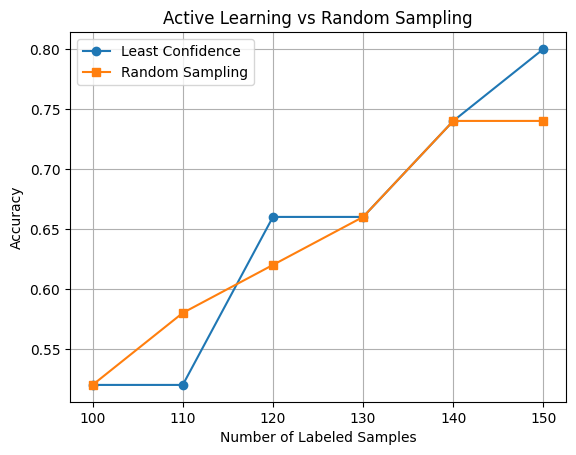

[ 0.   -0.06  0.04  0.    0.    0.06]
As the data increases, it is found that the difference increases


In [ ]:
# TODO: Run active learning with random sampling (baseline)
n_labels_history2, acc_history2  = run_active_learning_loop(X_seed, y_seed, X_pool, y_pool, X_test, y_test, random_sampling, steps=5, batch_size=10)
# TODO: Plot learning curves of active learning and random sampling wrt to number of samples
import matplotlib.pyplot as plt
import numpy as np

plt.plot(n_labels_history1, acc_history1, marker='o', label="Least Confidence")
plt.plot(n_labels_history2, acc_history2, marker='s', label="Random Sampling")

plt.xlabel("Number of Labeled Samples")
plt.ylabel("Accuracy")
plt.title("Active Learning vs Random Sampling")
plt.legend()
plt.grid(True)
plt.show()

# TODO: Print comparison summary for active learning and random sampling final accuracy
difference = np.array(acc_history1) - np.array(acc_history2)
print(difference)
print("As the data increases, it is found that the difference increases")

## Task 4: AI vs. AI (LLM & Noise Detection) (3 Marks)

**Objective:** Use LLMs for bulk labeling and detect hallucinations.

**Note:**

- Make an account at [open-router](https://openrouter.ai/) and get the API key.
- Use `google/gemini-2.5-flash-lite` (free tier) model as your LLM. Read the documentation on how to use it [here](https://openrouter.ai/google/gemini-2.5-flash-lite/api)
- Set environment variable using .env file and paste your API key in it.

### Part 4.1: LLM Pipeline with Few-Shot Prompting

Design a few-shot prompt with 3 examples from gold standard.
Send remaining unlabeled samples (~150) to Gemini API for labeling.

In [ ]:
import os
import time
import requests
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
API_KEY = "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"

SITE_URL = "http://localhost:8000"
SITE_NAME = "Student Lab Assignment"
MODEL_NAME = "google/gemini-2.5-flash-lite"

gold_examples = [
    {
        "review": "This movie is a triumph in every sense. Highly recommended for everyone.",
        "label": "Positive"
    },
    {
        "review": "I have never been so bored in my life. The score was frankly cringe-worthy. Avoid this at all costs.",
        "label": "Negative"
    },
    {
        "review": "Middle of the road entertainment. Visually it's fine, but the story arc is just average. It is what it is.",
        "label": "Neutral"
    }
]

def generate_few_shot_prompt(review_text, examples):
    instruction = """
You are a strict movie review sentiment classifier.

Classify the sentiment into exactly one of:
Positive
Negative
Neutral

Rules:
- Output ONLY one word.
- Do not explain.
- Do not add punctuation.
- If mixed sentiment, choose Neutral.
- If unclear, choose Neutral.
"""

    few_shot_block = ""
    for i, ex in enumerate(examples):
        few_shot_block += f"""
Example {i+1}:
Review: {ex['review']}
Label: {ex['label']}
"""

    final_prompt = f"""
{instruction}

{few_shot_block}

Now classify:

Review: {review_text}
Label:
"""
    return final_prompt


def query_openrouter(review_text, examples):
    url = "https://openrouter.ai/api/v1/chat/completions"

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "HTTP-Referer": SITE_URL,
        "X-Title": SITE_NAME,
        "Content-Type": "application/json"
    }

    prompt = generate_few_shot_prompt(review_text, examples)

    payload = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "temperature": 0
    }

    try:
        response = requests.post(url, headers=headers, json=payload)

        if response.status_code != 200:
            print("API Error:", response.status_code, response.text)
            return "INVALID"

        result = response.json()
        label = result["choices"][0]["message"]["content"].strip().capitalize()

        if label not in ["Positive", "Negative", "Neutral"]:
            return "INVALID"

        return label

    except Exception as e:
        print("Request failed:", e)
        return "INVALID"


if __name__ == "__main__":

    df = pd.read_csv("movie_reviews_300.csv", encoding="latin1")

    df_150 = df.tail(150).copy()
    df_150.reset_index(drop=True, inplace=True)

    llm_labels = []

    for i, review in enumerate(df_150["review"]):
        print(f"{i+1}/150")
        label = query_openrouter(review, gold_examples)
        llm_labels.append(label)
        time.sleep(1)

    df_150["llm_label"] = llm_labels

    df_150[["review", "llm_label"]].to_csv("llm_labels_150.csv", index=False)

    print("\n===== SUMMARY =====")
    print("Total samples:", len(df_150))
    print("Invalid outputs:", (df_150["llm_label"] == "INVALID").sum())

1/150
2/150
3/150
4/150
5/150
6/150
7/150
8/150
9/150
10/150
11/150
12/150
13/150
14/150
15/150
16/150
17/150
18/150
19/150
20/150
21/150
22/150
23/150
24/150
25/150
26/150
27/150
28/150
29/150
30/150
31/150
32/150
33/150
34/150
35/150
36/150
37/150
38/150
39/150
40/150
41/150
42/150
43/150
44/150
45/150
46/150
47/150
48/150
49/150
50/150
51/150
52/150
53/150
54/150
55/150
56/150
57/150
58/150
59/150
60/150
61/150
62/150
63/150
64/150
65/150
66/150
67/150
68/150
69/150
70/150
71/150
72/150
73/150
74/150
75/150
76/150
77/150
78/150
79/150
80/150
81/150
82/150
83/150
84/150
85/150
86/150
87/150
88/150
89/150
90/150
91/150
92/150
93/150
94/150
95/150
96/150
97/150
98/150
99/150
100/150
101/150
102/150
103/150
104/150
105/150
106/150
107/150
108/150
109/150
110/150
111/150
112/150
113/150
114/150
115/150
116/150
117/150
118/150
119/150
120/150
121/150
122/150
123/150
124/150
125/150
126/150
127/150
128/150
129/150
130/150
131/150
132/150
133/150
134/150
135/150
136/150
137/150
138/150
139/

In [ ]:
import json
df = pd.read_csv("llm_labels_150.csv")
records = df.to_dict(orient="records")

with open("llm_labels_150.json", "w", encoding="utf-8") as f:
    json.dump(records, f, indent=4, ensure_ascii=False)


### Part 4.2: Noise Hunting (Cleanlab Logic)

Train a Logistic Regression model on LLM-labeled data.
Identify "High Confidence Disagreements" where the model is very confident (>0.80) but disagrees with the LLM label.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv("llm_labels_150.csv")

review_texts = df["review"].tolist()
llm_labels = df["llm_label"].tolist()

label_mapping = {"Negative": 0, "Positive": 1, "Neutral": 2}
inverse_mapping = {0: "Negative", 1: "Positive", 2: "Neutral"}

llm_numeric = np.array([label_mapping[label] for label in llm_labels])

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_vec = vectorizer.fit_transform(review_texts)

model = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)

model.fit(X_vec, llm_numeric)

model_probs = model.predict_proba(X_vec)
preds = np.argmax(model_probs, axis=1)
confidences = np.max(model_probs, axis=1)

threshold = 0.80
mask = (preds != llm_numeric) & (confidences > threshold)
indices = np.where(mask)[0]

results = pd.DataFrame({
    "index": indices,
    "review": [review_texts[i] for i in indices],
    "llm_label": [inverse_mapping[llm_numeric[i]] for i in indices],
    "model_prediction": [inverse_mapping[preds[i]] for i in indices],
    "confidence": [round(confidences[i], 3) for i in indices]
}).sort_values(by="confidence", ascending=False)

print("Total high-confidence disagreements:", len(results))
print(results.head())

Total high-confidence disagreements: 0
Empty DataFrame
Columns: [index, review, llm_label, model_prediction, confidence]
Index: []


## Deliverables

**Submission Checklist:**
- [ ] Completed Jupyter Notebook with all tasks (Tasks 1-4)
- [ ] Include your label-studio annotation interface screenshot.
- [ ] gold_standard_100.csv
- [ ] weak_labels_200.csv
- [ ] llm_labels_150.json